# *Sentiment Analysis of Movie Reviews*

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ga201\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load the IMDB dataset
num_words = 10000
maxlen = 200
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words) 
# Only most frequent 10k words included in dictionary

## EDA and Visualization

In [4]:
print("Shape of training data:", X_train.shape)
print("Shape of training labels:", y_train.shape)

Shape of training data: (25000,)
Shape of training labels: (25000,)


In [5]:
data = np.concatenate((X_train, X_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)
print("Shape of data:", data.shape)
print("Shape of labels:", labels.shape)

Shape of data: (50000,)
Shape of labels: (50000,)


In [6]:
print("Number of positive reviews:", np.sum(labels == 1))
print("Number of negative reviews:", np.sum(labels == 0))

Number of positive reviews: 25000
Number of negative reviews: 25000


In [7]:
print("Number of positive reviews:", np.sum(y_train == 1))
print("Number of negative reviews:", np.sum(y_train == 0))

Number of positive reviews: 12500
Number of negative reviews: 12500


In [8]:
review_lengths = [len(review) for review in X_train]
print('Mean review length:', np.mean(review_lengths))
print('Median review length:', np.median(review_lengths))

Mean review length: 238.71364
Median review length: 178.0


### Visualization - *Pie Chart*

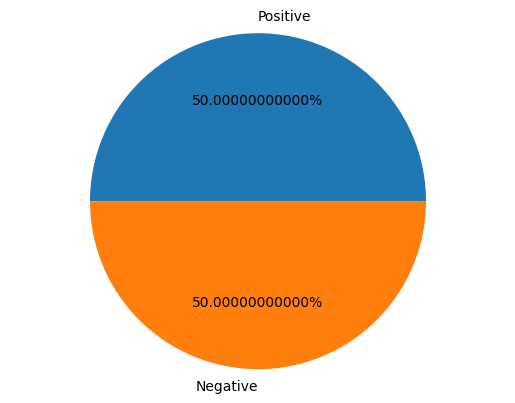

In [9]:
# Count the number of positive and negative reviews
positive_count = sum(y_train)
negative_count = len(y_train) - positive_count

# Plot a pie chart of the sentiment distribution
labels = ['Positive', 'Negative']
sizes = [positive_count, negative_count]
plt.pie(sizes, labels=labels, autopct='%1.11f%%')
plt.axis('equal')
plt.show()

### Visualization - *Histograms*

**Overall Review lengths**

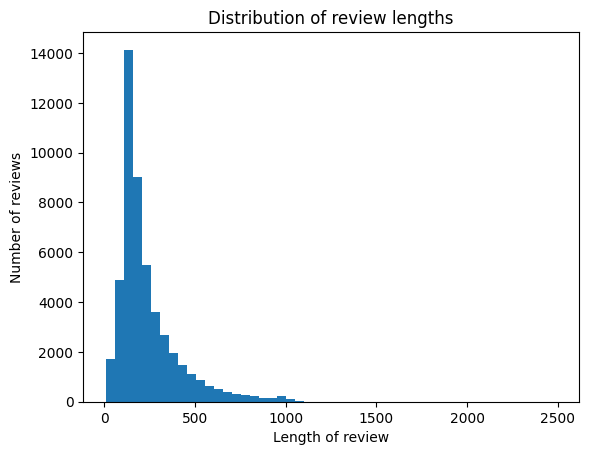

In [10]:
# Plot the distribution of review lengths
plt.hist([len(review) for review in data], bins=50)
plt.xlabel('Length of review')
plt.ylabel('Number of reviews')
plt.title('Distribution of review lengths')
plt.show()

**Negative Review lengths**

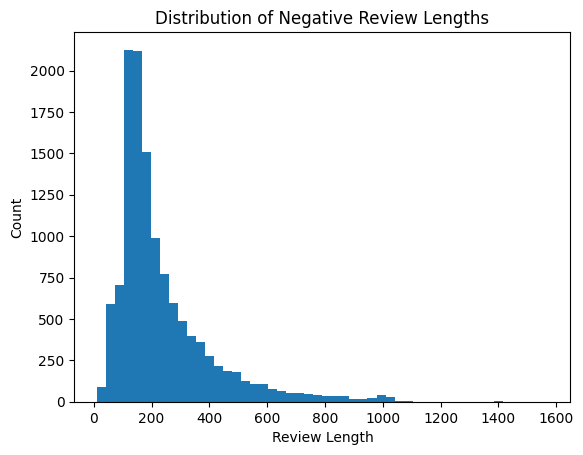

In [11]:
# Filtering the negative reviews
negative_reviews = [X_train[i] for i in range(len(X_train)) if y_train[i] == 0]
negative_review_lengths = [len(review) for review in negative_reviews]

# Plot the histogram of negative review lengths
plt.hist(negative_review_lengths, bins=50)
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.title('Distribution of Negative Review Lengths')
plt.show()

**Positive Review lengths**

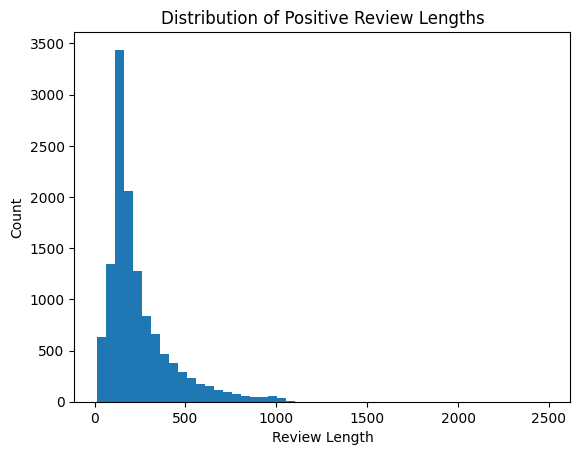

In [12]:
# Filtering the negative reviews
positive_reviews = [X_train[i] for i in range(len(X_train)) if y_train[i] == 1]
positive_review_lengths = [len(review) for review in positive_reviews]

# Plot the histogram of negative review lengths
plt.hist(positive_review_lengths, bins=50)
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.title('Distribution of Positive Review Lengths')
plt.show()

## Data Cleaning

In [13]:
# Word Index
# the data (words) are already encoded
word_index = imdb.get_word_index() # Get the dictionary mapping words to an integer index
word_index["<UNK>"] = 0 # UNKNOWN WORD


In [14]:
# Convert the integer sequences to text
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def encode_review(text):    
    return [word_index.get(i, 0)+3 for i in text.split(' ')]
def decode_review(text):
	return " ".join([reverse_word_index.get(i-3, "?") for i in text])

# this function will return the decoded (human readable) reviews  

decoded_review = decode_review(X_train[0])
#print(reverse_word_index)
# print(decoded_review)

In [15]:
# Print a sample review and its label
print("Sample review:")
print(decoded_review)
print("\nLabel:") # 1 is positive 0 is negative
print(y_train[0])

Sample review:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have don

In [16]:
stop_words = set(stopwords.words('english'))

In [17]:
# Clean the text by removing unwanted characters
def clean_text(text):
    text = re.sub('<[^>]*>', '', text)  # Remove HTML tags
    text = re.sub('/^\w+$/', ' ', text)  # Remove non-alphanumeric characters, we use \w to include latin letters for words like cliché
    text = re.sub('\s+', ' ', text)  # Remove extra whitespaces
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words if word in word_index]) #Remove stopwords and words not in word_index
    return text

X_train_cleaned = [clean_text(' '.join([reverse_word_index.get(i - 3, '?') for i in seq])) for seq in X_train]
X_test_cleaned = [clean_text(' '.join([reverse_word_index.get(i - 3, '?') for i in seq])) for seq in X_test]

In [18]:
# We re-encode the cleaned dataset using the same word index we imported from keras
X_train_cleaned_enc = []
X_test_cleaned_enc = []
for idx in range(len(X_train_cleaned)):
    encode_train = encode_review(X_train_cleaned[idx])
    encode_test = encode_review(X_test_cleaned[idx])
    X_train_cleaned_enc.append(encode_train)
    X_test_cleaned_enc.append(encode_test)

In [19]:
# Compare the initial input to the processed data
print(decode_review(X_train[0]))

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [20]:
print(decode_review(X_train_cleaned_enc[0]))

film brilliant casting location scenery story direction everyone's really suited part played could imagine robert amazing actor director father came scottish island loved fact real connection film witty remarks throughout film great brilliant much bought film soon released would recommend everyone watch fly fishing amazing really cried end sad know say cry film must good definitely also two little boy's played norman paul brilliant children often left list think stars play grown big profile whole film children amazing praised done think whole story lovely true someone's life shared us


In [21]:
# np.shape(X_train_cleaned_enc)

In [22]:
# Pad the sequences to ensure equal length
maxlen=250
X_train_pad = pad_sequences(X_train_cleaned_enc, value=0, padding='post', maxlen=250)
X_test = pad_sequences(X_test_cleaned_enc, value=0, padding='post', maxlen=250)
# pad the sequences of text data with zeros to make them of equal length
np.set_printoptions(threshold=np.inf)
print(X_train_pad.shape, X_train_pad[0])

(25000, 250) [  22  530  973 1622 1385   65  458 4468   66 3941  173  256  100  838
  670  480  284  167  336  385 4536 1111  447  192  147 2025   22 1920
 4613  469   22   87  530   76 1247   22  515  626   62  386  316  106
 2223 5244  480   66 3785  130  619  124  135 1415   22  215   52  407
   82  107  117 5952  256 3766  723  530  476  400  317 1029  104  381
  297 2071  194 7486  226   22  476  480 5535  224  104  226   65 1334
  283 4472  113 5345  178    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

### Further Split to Validation Data

In [23]:
split_len = int(len(X_train_pad)*0.2)
x_val = X_train_pad[:split_len]
x_train = X_train_pad[split_len:]

y_val = y_train[:split_len]
y_train2 = y_train[split_len:]

In [24]:
# np.shape(x_val)

## Model Selection and Design

In [25]:
# Set hyperparameters

max_features = len(word_index) # Maximum number of words to keep
max_length = 250 # Maximum sequence length (review word length)
embedding_dims = 50 # Dimensionality of word embeddings
filters = 250 # Number of filters to apply in the convolutional layer
kernel_size = 3 # Size of the convolutional kernel
hidden_dims = 250 # Number of hidden units in the dense layer
rnn_units = 128 # Number of RNN units
lstm_units = 128 # Number of LSTM units
batch_size = 32 # Size of each batch
epochs = 10 # Number of epochs to train for
learn_rate = 0.001 # The learning rate
drop_prob = 0.2 # Dropout layer probability

In [26]:
np.shape(X_train), np.shape(x_train)

((25000,), (20000, 250))

### 1. Simple Neural Network

In [27]:
model = keras.Sequential()
model.add(keras.layers.Embedding(max_features, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          1417360   
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,417,649
Trainable params: 1,417,649
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [29]:
# Training the model
fitModel = model.fit(x_train, y_train2, epochs=40, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/40
40/40 [==============================] - 3s 52ms/step - loss: 0.6916 - accuracy: 0.5642 - val_loss: 0.6886 - val_accuracy: 0.6182
Epoch 2/40
40/40 [==============================] - 2s 45ms/step - loss: 0.6822 - accuracy: 0.6811 - val_loss: 0.6735 - val_accuracy: 0.7734
Epoch 3/40
40/40 [==============================] - 2s 49ms/step - loss: 0.6580 - accuracy: 0.8066 - val_loss: 0.6411 - val_accuracy: 0.8240
Epoch 4/40
40/40 [==============================] - 2s 50ms/step - loss: 0.6143 - accuracy: 0.8396 - val_loss: 0.5922 - val_accuracy: 0.8228
Epoch 5/40
40/40 [==============================] - 2s 43ms/step - loss: 0.5553 - accuracy: 0.8518 - val_loss: 0.5340 - val_accuracy: 0.8334
Epoch 6/40
40/40 [==============================] - 2s 42ms/step - loss: 0.4915 - accuracy: 0.8623 - val_loss: 0.4768 - val_accuracy: 0.8464
Epoch 7/40
40/40 [==============================] - 2s 43ms/step - loss: 0.4328 - accuracy: 0.8763 - val_loss: 0.4295 - val_accuracy: 0.8554
Epoch 8/40
40

In [30]:
# Evaluate RNN model
y_pred = model.predict(X_test).ravel()
y_pred_rounded = np.rint(y_pred)

loss, accuracy = model.evaluate(X_test, y_test, batch_size=512)
# Print the test set loss and accuracy
print('Test loss:', loss)
print('Test accuracy:', accuracy)

49/49 [==============================] - 0s 6ms/step - loss: 0.3621 - accuracy: 0.8737
Test loss: 0.3620883524417877
Test accuracy: 0.8737199902534485


Confusion matrix:
 [[10890  1610]
 [ 1547 10953]]


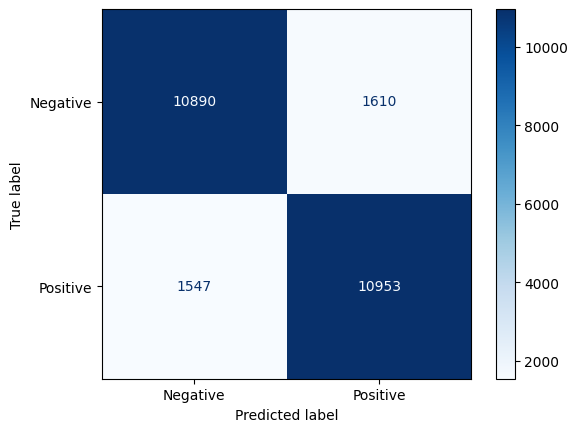

In [46]:
# confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_rounded)
print('Confusion matrix:\n', cm_rnn)
ConfusionMatrixDisplay(cm_rnn, display_labels=["Negative","Positive"]).plot(cmap=plt.cm.Blues)

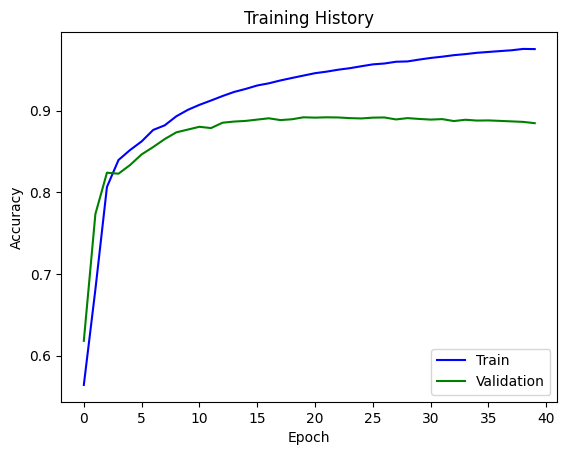

In [31]:
plt.plot(fitModel.history['accuracy'], c="b")
plt.plot(fitModel.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

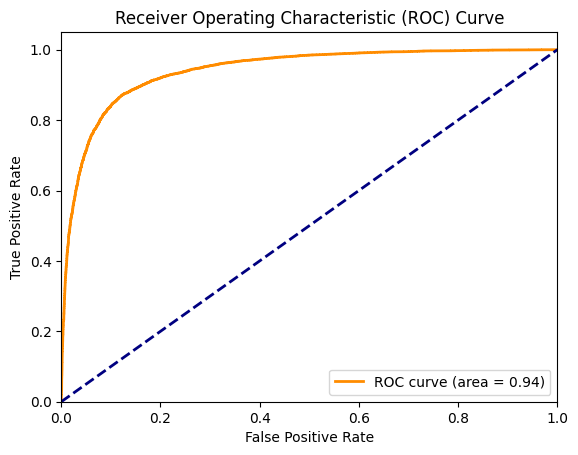

In [47]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### 2. RNN Network

In [36]:
# delete old model before trying again
# del rnn_model

# Build RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(len(word_index), embedding_dims, input_length=max_length, mask_zero=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(rnn_units, activation='linear'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1, activation='sigmoid'))

# Compile model
my_optimizer=Adam(learning_rate=0.0001)
rnn_model.compile(loss='binary_crossentropy', optimizer=my_optimizer, metrics=['accuracy'])


In [37]:
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 50)           4429250   
                                                                 
 dropout_2 (Dropout)         (None, 250, 50)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               22912     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,452,291
Trainable params: 4,452,291
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Train RNN model
history_rnn = rnn_model.fit(x_train, y_train2, batch_size=128, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
157/157 [==============================] - 55s 335ms/step - loss: 0.6937 - accuracy: 0.5332 - val_loss: 0.6801 - val_accuracy: 0.5718
Epoch 2/10
157/157 [==============================] - 51s 326ms/step - loss: 0.5987 - accuracy: 0.6962 - val_loss: 0.4720 - val_accuracy: 0.7984
Epoch 3/10
157/157 [==============================] - 60s 384ms/step - loss: 0.4025 - accuracy: 0.8400 - val_loss: 0.3798 - val_accuracy: 0.8528
Epoch 4/10
157/157 [==============================] - 55s 348ms/step - loss: 0.2910 - accuracy: 0.8897 - val_loss: 0.3262 - val_accuracy: 0.8682
Epoch 5/10
157/157 [==============================] - 56s 358ms/step - loss: 0.2646 - accuracy: 0.9036 - val_loss: 0.3104 - val_accuracy: 0.8704
Epoch 6/10
157/157 [==============================] - 55s 349ms/step - loss: 0.2122 - accuracy: 0.9238 - val_loss: 0.2987 - val_accuracy: 0.8770
Epoch 7/10
157/157 [==============================] - 53s 338ms/step - loss: 0.1906 - accuracy: 0.9351 - val_loss: 0.3359 - val_ac

In [42]:
# Evaluate RNN model
y_pred_rnn = rnn_model.predict(X_test).ravel()
y_pred_rnn_rounded = np.rint(y_pred_rnn)

loss, accuracy_rnn = rnn_model.evaluate(X_test, y_test, batch_size=128)
# Print the test set loss and accuracy
print('Test loss:', loss)
print('Test accuracy:', accuracy_rnn)

196/196 [==============================] - 23s 118ms/step - loss: 0.3657 - accuracy: 0.8668
Test loss: 0.3657373785972595
Test accuracy: 0.8667600154876709


In [ ]:
plt.plot(rnn_model.history['accuracy'], c="b")
plt.plot(rnn_model.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Confusion matrix:
 [[10841  1659]
 [ 1672 10828]]


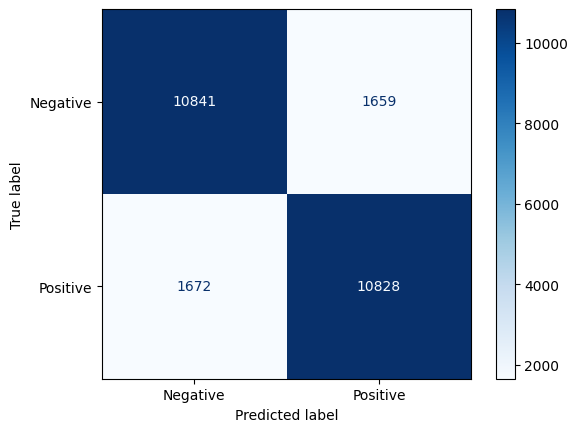

In [44]:
# confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn_rounded)
print('Confusion matrix:\n', cm_rnn)
ConfusionMatrixDisplay(cm_rnn, display_labels=["Negative","Positive"]).plot(cmap=plt.cm.Blues)

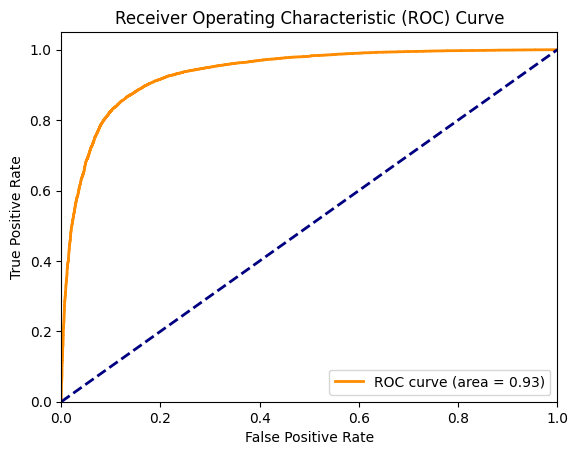

In [45]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rnn)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()